## Eigenvalue clipping for covariance matrix

In [1]:
# read paquet file

import polars as pl

data = pl.read_parquet("covariance/covs_matrix.parquet")

data = data.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

In [2]:
import numpy as np

def cov_matrix(covs_row: pl.Series, Countries_indexes: list, suffix = ""):
    '''
    Takes as input a row of the covs matrix and the indexes of the countries and returns the Covariance matrix based on that row.
    '''
    cov = np.zeros((len(Countries_indexes), len(Countries_indexes)))
    for i in range(len(Countries_indexes)):
        for j in range(i,len(Countries_indexes)):
            cov[i,j] = cov[j,i] = covs_row[f"{Countries_indexes[i]}_{Countries_indexes[j]}" + suffix][0]
    return cov

Countries_indexes = ["EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"]

In [3]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import seaborn as sns


def eigenvalue_clipping(lambdas,v,lambda_plus, print_log=False):
    N=len(lambdas)
    
    
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas.copy()
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
        
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 

    if print_log:
        print("Size of the bulk",N_bulk)
        print("Percentage of the bulk",sum_lambda_bulk/sum(lambdas))      
        print(lambdas_clean)
  


    return C_clean


In [4]:
cov1 = cov_matrix(data[12], Countries_indexes)
l_e, V_e = LA.eig(cov1)
mean_variance = np.mean(np.diag(cov1))

<AxesSubplot: ylabel='Count'>

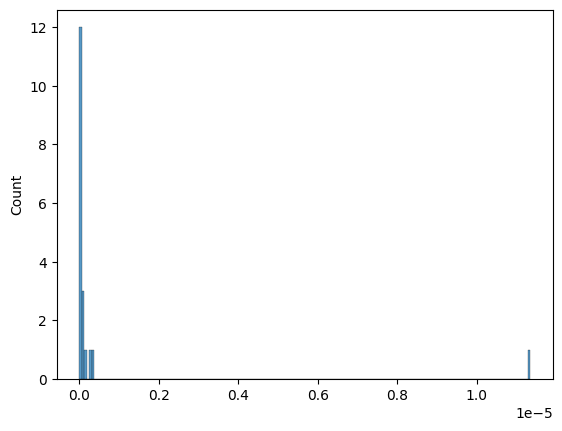

In [5]:
sns.histplot(l_e)  # no Kernel Density Estimation

In [6]:
N = 20
T = 60

q = N/T
lambda_plus = (1+np.sqrt(q))**2 * mean_variance 

cov_clipped = eigenvalue_clipping(l_e, V_e, lambda_plus)

[7.09980515e-08+0.00000000e+00j 1.13467144e-05+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+1.23202714e-22j
 7.09980515e-08-1.23202714e-22j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j 7.09980515e-08+0.00000000e+00j
 7.09980515e-08+0.00000000e+00j]


c:\Users\Amirmahdi\anaconda3\envs\ada_exam_2024\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


<AxesSubplot: ylabel='Count'>

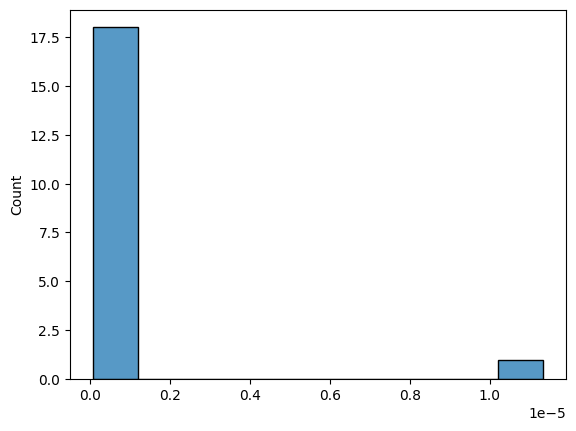

In [7]:
# check the eigenvalues
l_e_clipped, V_e_clipped = LA.eig(cov_clipped)

print(l_e_clipped)

sns.histplot(l_e_clipped, bins = 10)  # no Kernel Density Estimation

In [8]:
from tqdm import tqdm

In [9]:
def mvp_weights(covariance_marix):
    return np.linalg.inv(covariance_marix).sum(axis=1) / np.linalg.inv(covariance_marix).sum()

# we calculate the optimal weights using the estimated covariance matrix, by either clipping or naive estimation.
# Then we calculate the in-sample/out-of-sample risk using the optimal weights and the current/future true covariance matrix.
def risk_calculation(cov1, cov2):
    weights = mvp_weights(cov1)
    risk = np.dot(weights.T, np.dot(cov2, weights))
    return risk.item()


In [10]:
n = 120

data_shifted = data.with_columns([
    data[col].shift(-n).alias(f"{col}_{n}") for col in data.columns
])

column_names = data_shifted.columns

# drop last n rows
data_shifted = data_shifted.slice(0, -n)

In [26]:
def row_in_sample_out_sample(row: pl.Series):
    # Calculate the covariance matrix from the row
    # row = pl.DataFrame([row], schema=column_names)
    cov_1 = cov_matrix(row, Countries_indexes)
    cov_2 = cov_matrix(row, Countries_indexes, f"_{n}")
    
    # Eigenvalue decomposition
    l_e, V_e = np.linalg.eig(cov_1)
    mean_variance = np.mean(np.diag(cov_1))
    
    # Define parameters
    N = len(Countries_indexes)
    T = 60
    q = N / T
    lambda_plus = (1 + np.sqrt(q))**2 * mean_variance

    # Perform eigenvalue clipping
    cov_clipped = eigenvalue_clipping(l_e, V_e, lambda_plus)

    # Calculate in-sample risk
    in_sample_risk = risk_calculation(cov_clipped, cov_1)
    out_sample_risk = risk_calculation(cov_clipped, cov_2)


    in_sample_risk = np.nan if isinstance(in_sample_risk, complex) else in_sample_risk
    out_sample_risk = np.nan if isinstance(out_sample_risk, complex) else out_sample_risk

    # Handle potential complex values in risk
    return in_sample_risk, out_sample_risk



# risks = data_shifted[:1000, :].map_rows(lambda row: row_in_sample_out_sample(row))

# risks = data.with_columns(
#     data.map_rows(lambda row: row_in_sample_out_sample(row)).alias("risk")
# )
# # Forward-fill NaN values in Polars
# risks_filled = risks.with_column(
#     pl.col("risk").fill_null(strategy="forward")
# )

in_sample_risks = []
out_sample_risks = []

for i in tqdm(range(1000)):
    in_sample_risk, out_sample_risk = row_in_sample_out_sample(data_shifted[i])
    in_sample_risks.append(in_sample_risk)
    out_sample_risks.append(out_sample_risk)
#     # print(in_sample_risk, out_sample_risk)
#     # break

risks = pl.DataFrame({
    "in_sample": in_sample_risks,
    "out_sample": out_sample_risks
})

# Forward fill the columns
risks_filled = risks.with_columns(
    [
        pl.col("in_sample").fill_null(strategy="forward").alias("in_sample"),
        pl.col("out_sample").fill_null(strategy="forward").alias("out_sample")
    ]
)

100%|██████████| 1000/1000 [00:05<00:00, 182.17it/s]


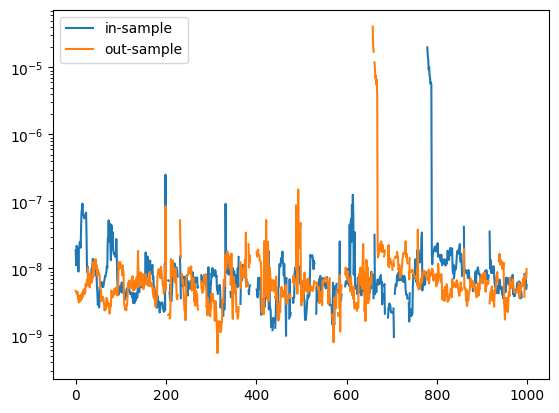

In [28]:
import matplotlib.pyplot as plt

plt.plot(risks_filled["in_sample"], label="in-sample")
plt.plot(risks_filled["out_sample"], label="out-sample")
plt.legend()
plt.yscale("log")
plt.show()